In [19]:
# made by Gibeom LEE, HI LAB
# 전류 데이터를 적분하여 전하로 만들어줍니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
import os

13.16095
-13.48125
26.6422


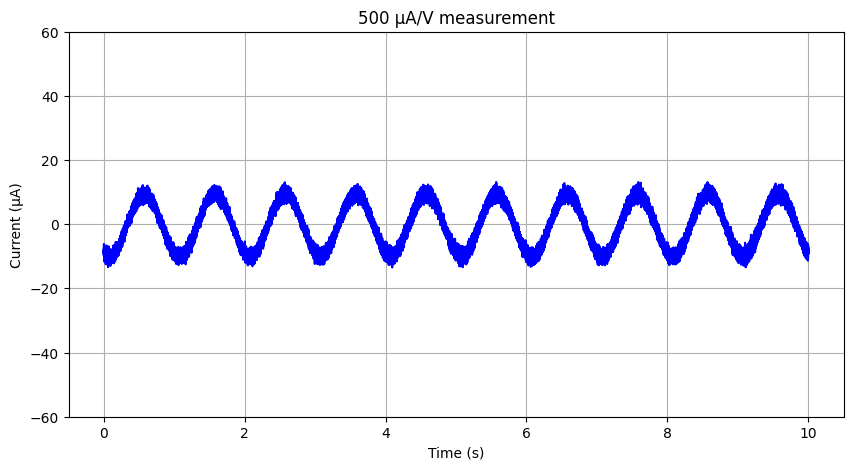

In [23]:
# fp는 업로드 된 파일, lp는 컴퓨터 내 파일. r주소
file_path = "data/0M teng 2.csv"
local_path = r"C:\Users\GCU\OneDrive - gachon.ac.kr\HI Lab\0. Projects\0. On going\2. Aloe inspired DEG\0. 실험자료\2. Collecting data\250410_이상전류\function generator csv파일\500ua.csv"

# file path 불러오기
#df = pd.read_csv(file_path, header=None, skiprows=30)
# local path 불러오기
df = pd.read_csv(local_path, header=None, skiprows=30)
# 데이터 로드 (처음 30행 스킵)

df.columns = ["Time", "Current"]

# 데이터 형식 변환...글자 -> NaN
df["Time"] = pd.to_numeric(df["Time"], errors='coerce')
df["Current"] = pd.to_numeric(df["Current"], errors='coerce')

#    *(10) = 10 μA/V 기준  %%%%%%%%% 중요 %%%%%%%%% 중요 %%%%%%%%% 중요 %%%%%%%%% 중요 %%%%%%%%% 중요 %%%%%%%%% 중요 %%%%%%%%% 
df["Current"] = df["Current"]*(500)

print(df.iloc[:, 1].max(skipna=True))
print(df.iloc[:, 1].min(skipna=True))
print(df.iloc[:, 1].max(skipna=True)-df.iloc[:, 1].min(skipna=True))
plt.figure(figsize=(10, 5))
plt.plot(df.iloc[:, 0], df.iloc[:, 1], label="AC current", color='b')
plt.xlabel("Time (s)")
plt.ylabel("Current (μA)")
plt.title("500 μA/V measurement")
plt.ylim(-60,60)
plt.grid(True)
plt.show()


양수 전하 값: 0.0025 C
음수 전하 값: -0.0016 C


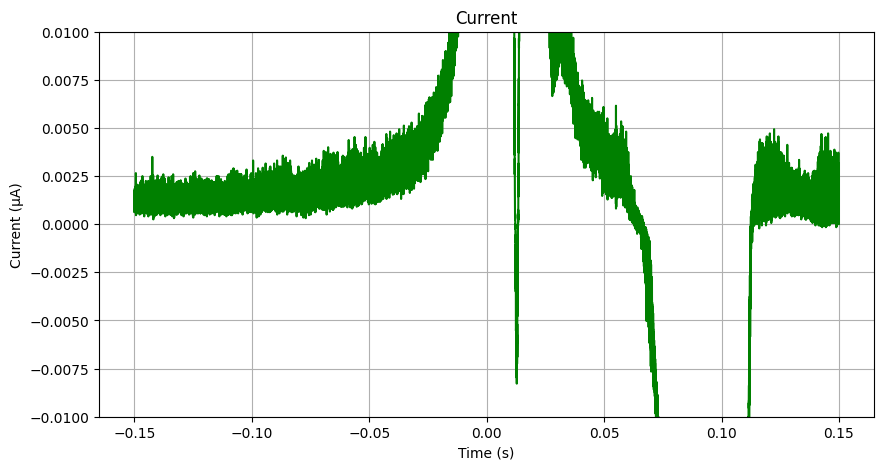

In [26]:
# 2. 특정 범위 선택      ########################## MUST BE MODIFIED MANUALLY
time_range = (-0.15, 0.15) #unit = sec
df_filtered = df[(df.iloc[:, 0] >= time_range[0]) & (df.iloc[:, 0] <= time_range[1])]

# 3. 양수 및 음수 전류값 분리
p_value = df_filtered[df_filtered.iloc[:, 1] > 0]
n_value = df_filtered[df_filtered.iloc[:, 1] < 0]

# 4. 적분을 위한 시간과 전류값 배열 생성
p_time = p_value.iloc[:, 0].values
p_current = p_value.iloc[:, 1].values

n_time = n_value.iloc[:, 0].values
n_current = n_value.iloc[:, 1].values

# 5. 양수/음수 적분 (전하 계산)
p_charge = cumulative_trapezoid(p_current, p_time, initial=0)[-1] if len(p_time) > 1 else 0
n_charge = cumulative_trapezoid(n_current, n_time, initial=0)[-1] if len(n_time) > 1 else 0

print(f"양수 전하 값: {p_charge:.4f} C")
print(f"음수 전하 값: {n_charge:.4f} C")

plt.figure(figsize=(10, 5))
plt.plot(df_filtered.iloc[:, 0], df_filtered.iloc[:, 1], label="Current", color='g')
plt.xlabel("Time (s)")
plt.ylabel("Current (μA)") ### 단위 고려 중요
plt.title("Current")
plt.ylim(-0.01, 0.01)
#plt.legend()
plt.grid(True)
plt.show()


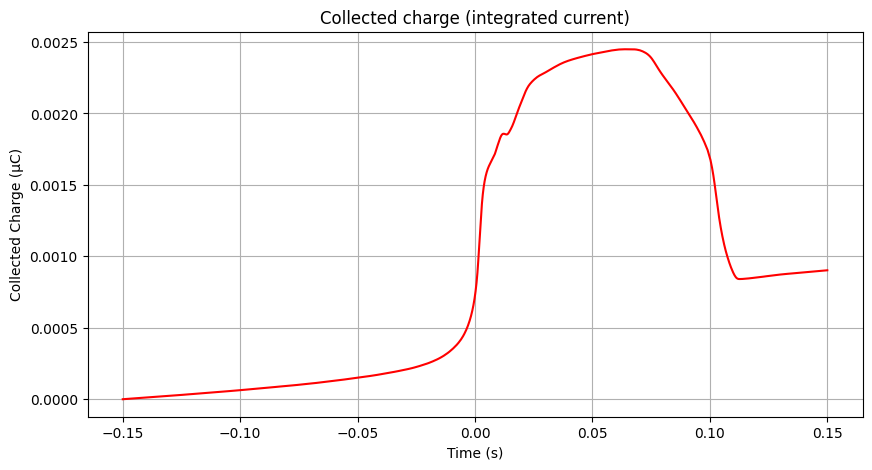

In [23]:
# 6. 중첩 적분 수행 (누적 전류)
cumulative_charge = cumulative_trapezoid(df_filtered.iloc[:, 1], df_filtered.iloc[:, 0], initial=0)

# 7. 중첩 적분 결과 플로팅
plt.figure(figsize=(10, 5))
plt.plot(df_filtered.iloc[:, 0], cumulative_charge, label="Cumulative Charge", color='r')
plt.xlabel("Time (s)")
plt.ylabel("Collected Charge (μC)") ####단위 고려 중요요
plt.title("Collected charge (integrated current)")
#plt.legend()
plt.grid(True)
plt.show()